In [ ]:
"""
Generate data with specified changepoints
Compare ELBO fits for changepoint model with different
numbers of changepoints
"""

In [12]:
import os
import pickle
import scipy.stats as stats
import pymc3 as pm
import theano.tensor as tt
import numpy as np
import pylab as plt
import sys
from tqdm import tqdm

sys.path.append('/media/bigdata/firing_space_plot/changepoint_mcmc')
import poisson_all_tastes_changepoint_model as changepoint 

[154 477 707]
[   0  154  477  707 1000]
(10, 1000)
(1, 1, 10, 1000)


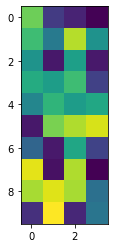

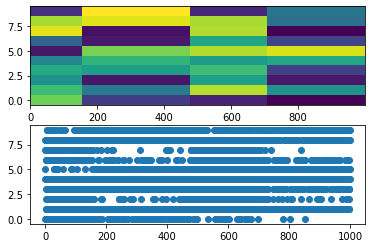

In [9]:
# Some poisson spiking
length = 1000
states = 4
nrns = 10
fit = 100000
samples = 20000
idx = np.arange(length)

true_tau = np.cumsum(np.random.random(states))
true_tau /= np.max(true_tau)
true_tau *= length
true_tau = np.vectorize(np.int)(true_tau)
state_inds = np.concatenate([np.zeros((1)),true_tau])
state_inds = np.vectorize(np.int)(state_inds)
true_tau = true_tau[:-1]

true_lambda = np.random.random((nrns,states))

print(true_tau)
print(state_inds)
plt.imshow(true_lambda)

true_r = np.zeros((nrns,length))
print(true_r.shape)
for nrn_num in range(nrns):
    for num, val in enumerate(true_lambda[nrn_num]):
        true_r[nrn_num, state_inds[num]:state_inds[num+1]] = val

data_vec = np.random.random(true_r.shape) < true_r
    
fig,ax = plt.subplots(2,1)
ax[0].imshow(true_r,origin='lower',aspect='auto')
ax[1].scatter(*np.where(data_vec)[::-1])

data_vec = data_vec[np.newaxis,np.newaxis,:,:]
print(data_vec.shape)

In [14]:
num_states = np.arange(2,6)
print(num_states)
model_list = [changepoint.create_changepoint_model(\
                spike_array = data_vec, states = state_num, fit=fit, samples=samples) \
              for state_num in tqdm(num_states)]

  0%|          | 0/4 [00:00<?, ?it/s]

[2 3 4 5]


INFO (theano.gof.compilelock): Waiting for existing lock by process '19579' (I am process '55728')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/abuzarmahmood/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.10-64/lock_dir


KeyboardInterrupt: 

In [147]:
def fit_model(model,fit,samples):
    with model:
        inference = pm.ADVI('full-rank')
        approx = pm.fit(n=fit, method=inference)
        trace = approx.sample(draws=samples)
    return approx,trace

In [148]:
fit_list = [fit_model(this_model,fit,samples) for this_model in model_list]

Average Loss = 694.73: 100%|██████████| 100000/100000 [00:31<00:00, 3128.26it/s]
Finished [100%]: Average Loss = 694.73
Average Loss = 685.34: 100%|██████████| 100000/100000 [00:34<00:00, 2863.75it/s]
Finished [100%]: Average Loss = 685.34
INFO (theano.gof.compilelock): Refreshing lock /home/abuzarmahmood/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.10-64/lock_dir/lock
Average Loss = 688.96: 100%|██████████| 100000/100000 [00:37<00:00, 2688.00it/s]
Finished [100%]: Average Loss = 688.97
Average Loss = 692.11: 100%|██████████| 100000/100000 [00:39<00:00, 2544.79it/s]
Finished [100%]: Average Loss = 692.12


In [149]:
# with model:
#         inference = pm.ADVI('full-rank')
#         approx = pm.fit(n=fit, method=inference)
#         trace = approx.sample(draws=samples)

In [150]:
len(fit_list[0])

2

/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


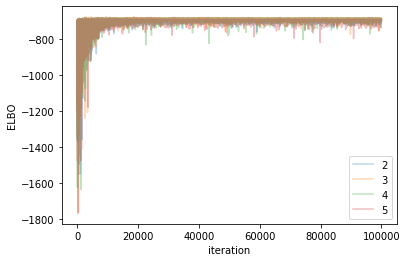

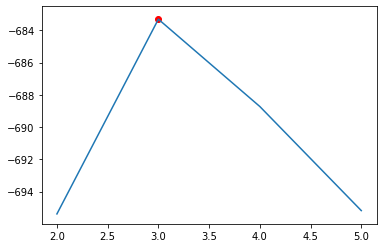

In [151]:
for num, this_fit in enumerate(fit_list):
    plt.plot(-this_fit[0].hist, label=num_states[num], alpha=.3)
plt.legend()
plt.ylabel('ELBO')
plt.xlabel('iteration');

# Plot final value
plt.figure()
fin_elbo = [-x[0].hist[-1] for x in fit_list]
plt.plot(num_states,fin_elbo)
max_elbo = np.max(fin_elbo)
plt.scatter(num_states[np.where(fin_elbo == max_elbo)[0]],max_elbo,c='red')

In [152]:
ppc_list = [pm.sample_posterior_predictive(this_fit[1], samples = 2000, model = this_model) \
            for this_fit, this_model in zip(fit_list,model_list)]

/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 2000/2000 [00:03<00:00, 533.39it/s]


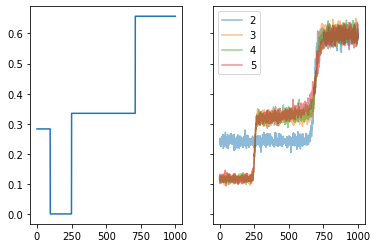

In [153]:
fig,ax = plt.subplots(1,2,sharey=True)
ax[0].plot(true_r)
for num, this_ppc in enumerate(ppc_list):
    ax[1].plot(np.mean(this_ppc['obs'],axis=0), label=num_states[num], alpha=.5)
plt.legend()

In [154]:
tau_list = [this_fit[1]['tau'] for this_fit in fit_list]

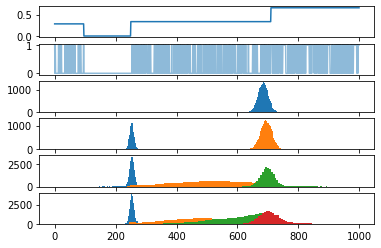

In [155]:
fig,ax = plt.subplots(2+len(tau_list),1,sharex=True)
ax[0].plot(true_r)
ax[1].plot(data_vec,alpha = 0.5)
for num, this_fit in enumerate(tau_list):
    for this_tau in this_fit.T:
        ax[2+num].hist(this_tau,bins=50)